# Tutorial vignette

## Import packages
We import the `GPA` class from our `Procrustes` module, along with a few other standard packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from Procrustes import GPA

## Generate data
In this tutorial, the base shape we shall use is a randomly generated smiley face.

In [3]:
rng = np.random.default_rng(seed=45)
t1 = 2 * np.pi * rng.uniform(size=25)
X1 = np.vstack([1 + 0.6 * np.cos(t1), 1.5 + 0.6 * np.sin(t1)]).T
t2 = 2 * np.pi * rng.uniform(size=25)
X2 = np.vstack([-1 + 0.6 * np.cos(t2), 1.5 + 0.6 * np.sin(t2)]).T
t3 = np.pi + np.pi * rng.uniform(size=30)
X3 = np.vstack([1.4 * np.cos(t3), -0.2 + 1.4 * np.sin(t3)]).T
t4 = rng.uniform(-1.4, 1.4, size=20)
X4 = np.vstack([t4, np.zeros(20) - 0.2]).T

X = np.vstack([X1, X2, X3, X4])

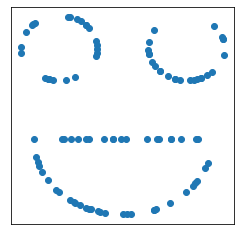

In [4]:
plt.figure(figsize=(4,4))
plt.scatter(*zip(*X))
plt.xticks([])
plt.yticks([])
plt.show()

We generate ten copies of this base shape, and apply random translations, dilations, and rotations.  

Note that the input to `GPA` is a $k \times n \times d$ `numpy` array, where:
- $k$ is the number of samples to align
- $n$ is the number of points in each samples
- $d$ is the dimension of the ambient space containing each sample

In [5]:
k = 10
n, d = X.shape

rng = np.random.default_rng(7)

# c = np.zeros(shape=(k,2))
c = rng.uniform(-5, 5, size=(k, 2))

# s = np.ones(shape=k)
s = rng.uniform(0.5, 2, size=k)

# q = np.stack([np.eye(2) for _ in range(k)])
t = 2 * np.pi * rng.uniform(size=k)
q = np.vstack([np.cos(t), -np.sin(t), np.sin(t), np.cos(t)]).T.reshape(k,2,2)

Y = c[:, np.newaxis, :] + s[:, np.newaxis, np.newaxis] * (X + rng.normal(scale=0.0, size=(k,n,d))) @ q

Here is a picture of our dataset, colored by sample.  The goal is to find the transformations that align each sample back to something like the base shape.

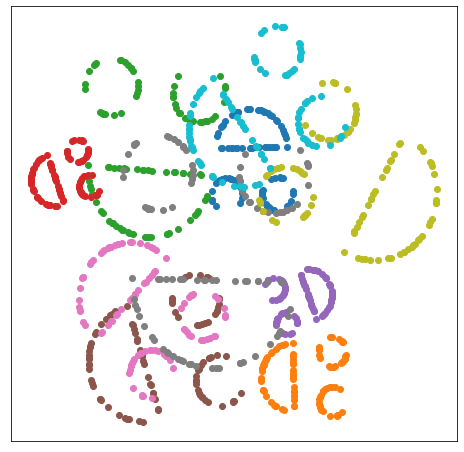

In [6]:
plt.figure(figsize=(8,8))
for i in range(len(Y)):
    plt.scatter(*zip(*Y[i]))

plt.xticks([])
plt.yticks([])
plt.show()

## Generalized Procrustes Alignment

### Basic usage
We demonstrate a basic application of our algorithm for the generalized Procrustes problem.  Note that we have to explicitly set `scaling=True` to allow dilations as possible transformations, since they are not isometries.

In [7]:
gpa = GPA(max_iter=1000, centering=True, scaling=True, verbose=True)

In [8]:
%%time
Y_fit = gpa.fit_transform(Y)

iteration 1: loss = 3.325358
iteration 2: loss = 0.000000
iteration 3: loss = 0.000000
CPU times: user 14.6 ms, sys: 2.5 ms, total: 17.1 ms
Wall time: 5.43 ms


Here we show the results.  On the left, we have an overlay of the ten samples after alignment, as returned by `GPA.fit_transform`.  On the right, we have the geometric centroid of the aligned samples, stored in `GPA.Z`.  Looks pretty good!

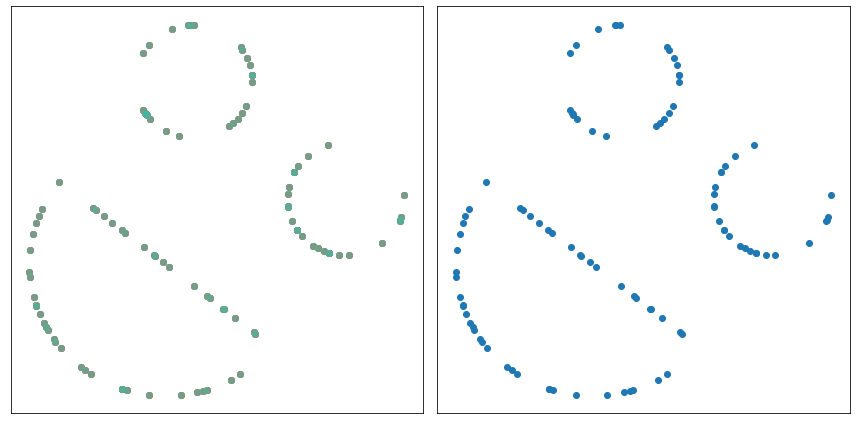

In [9]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,6), sharex=True, sharey=True)
for i in range(len(Y_fit)):
    ax0.scatter(*zip(*Y_fit[i]), alpha=0.3)
ax1.scatter(*zip(*gpa.Z))

ax0.set_xticks([])
ax0.set_yticks([])
ax1.set_xticks([])
ax1.set_yticks([])
plt.tight_layout()
plt.show()

For finetuning, the optimal transformations found by the algorithm can be accessed via:
- `GPA.c` for the translations $c$
- `GPA.s` for the dilation factor $s$
- `GPA.q` for the rotations and reflection, represented by the orthogonal matrix $Q$.

These are defined so that the transformation is given by $X \mapsto c + s X Q$.  For more details, see the attached document detailing the alternating minimization algorithm.

These optimal transformations are given in a stacked array.  The first dimension is the sample index.

As an example, here are the fitted rotation matrices visualized as heatmaps of their numerical entries.

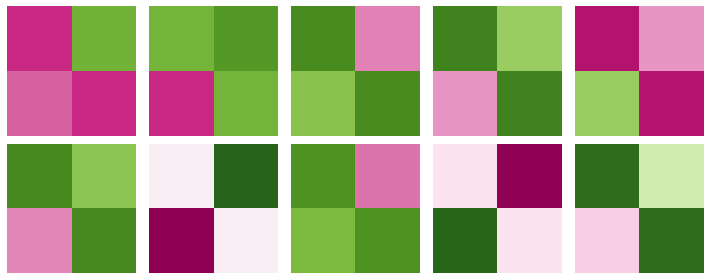

In [10]:
fig, axs = plt.subplots(2, 5, figsize=(10,4))
for i, ax in enumerate(fig.axes):
    ax.pcolormesh(gpa.q[i], vmin=-1, vmax=1, cmap='PiYG')
    ax.invert_yaxis()
    ax.axis('off')
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()

## Missing data
One strength of the formulation of the Procrustes problem is its ability to handle missing values.  Here, we create a masked copy of our dataset with 500 random entries (25% of the data) blanked out, and perform the alignment again.

In [11]:
Y_masked = Y.copy()
for i, j in rng.choice(list(np.ndindex(k,n)), 500):
    Y_masked[i,j,:] = np.nan

In [12]:
gpa = GPA(max_iter=1000, centering=True, scaling=True, verbose=True)

In [13]:
%%time
Y_masked_fit = gpa.fit_transform(Y_masked)

iteration 1: loss = 2.242277
iteration 2: loss = 0.764816
iteration 3: loss = 0.167597
iteration 4: loss = 0.067457
iteration 5: loss = 0.013241
iteration 6: loss = 0.004046
iteration 7: loss = 0.001558
iteration 8: loss = 0.000410
iteration 9: loss = 0.000110
iteration 10: loss = 0.000044
iteration 11: loss = 0.000011
iteration 12: loss = 0.000004
iteration 13: loss = 0.000002
iteration 14: loss = 0.000000
iteration 15: loss = 0.000000
iteration 16: loss = 0.000000
iteration 17: loss = 0.000000
iteration 18: loss = 0.000000
iteration 19: loss = 0.000000
iteration 20: loss = 0.000000
iteration 21: loss = 0.000000
iteration 22: loss = 0.000000
CPU times: user 64.6 ms, sys: 8.08 ms, total: 72.7 ms
Wall time: 32.8 ms


Here are the results, in the same format as above.  Still not too shabby!

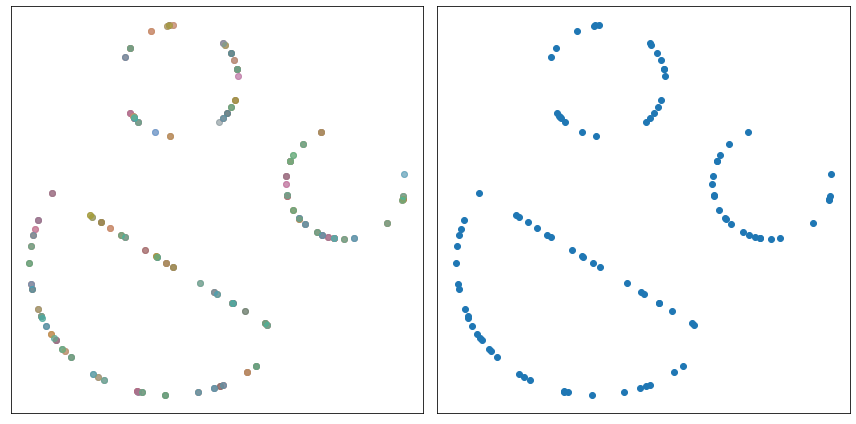

In [14]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,6), sharex=True, sharey=True)
for i in range(len(Y_masked_fit)):
    ax0.scatter(*zip(*Y_masked_fit[i]), alpha=0.3)
ax1.scatter(*zip(*gpa.Z))

ax0.set_xticks([])
ax0.set_yticks([])
ax1.set_xticks([])
ax1.set_yticks([])

plt.tight_layout()
plt.show()

## Geometric medians

Previously, the "average" was computed by taking the geometric centroid of the aligned samples.  Here, we compute the geometric *median* instead, using a modified Weiszfeld algorithm by Vardi and Zhang.  Note, this takes much longer to run.

In [15]:
gpa = GPA(max_iter=1000, p=1, centering=True, scaling=True, verbose=True)

In [16]:
%%time
Y_l1_fit = gpa.fit_transform(Y)

iteration 1: loss = 2.997001
iteration 2: loss = 0.000000
iteration 3: loss = 0.000000
CPU times: user 1.14 s, sys: 14.1 ms, total: 1.16 s
Wall time: 910 ms


Here are the result again.  Since the alignment is so good, it makes essentially no difference whether we take the $\ell_2$-minimizer or the $\ell_1$-minimizer.

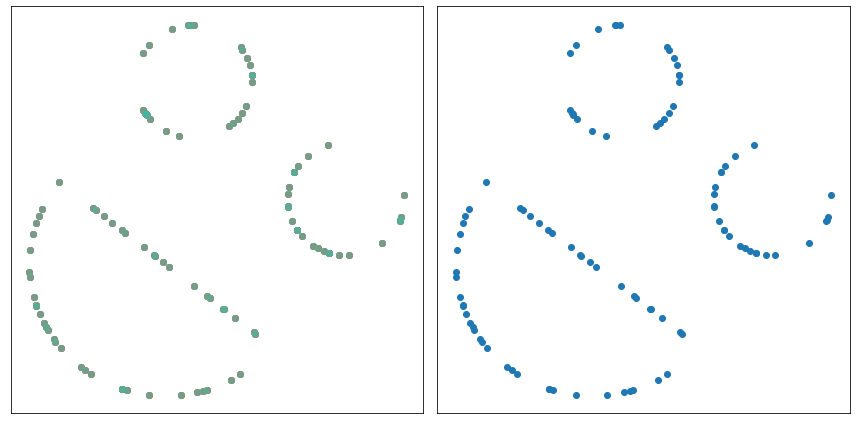

In [17]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12,6), sharex=True, sharey=True)
for i in range(len(Y_l1_fit)):
    ax0.scatter(*zip(*Y_l1_fit[i]), alpha=0.3)
ax1.scatter(*zip(*gpa.Z))

ax0.set_xticks([])
ax0.set_yticks([])
ax1.set_xticks([])
ax1.set_yticks([])

plt.tight_layout()
plt.show()